# Import

In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas & ML
import numpy as np
import pandas as pd

sns.set()

# Pandas & ML
from sklearn import metrics, preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

# Third party
import evidently
import shap

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# load cleaned data
app_train = pd.read_pickle("../data/processed/app_train_cleaned.pkl").set_index(
    "SK_ID_CURR"
)
app_test = pd.read_pickle("../data/processed/app_test_cleaned.pkl").set_index(
    "SK_ID_CURR"
)  # used for datadrift only

In [3]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 243 entries, NAME_CONTRACT_TYPE to FE_PAYMENT_RATE
dtypes: bool(130), float64(71), int64(42)
memory usage: 305.6 MB


# Split train/test
To keep some test data not seen by gridsearch

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train.drop("TARGET", axis=1), app_train.TARGET, test_size=0.15
)

## Naive undersampler to fix target imbalance

In [5]:
def NaiveUnderSampler(df):
    # find the minority class
    min_class = df.TARGET.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = df[df.TARGET == min_class].shape[0]
    df_balanced = pd.concat(
        [
            df[df.TARGET == min_class].sample(target_minority_count),
            df[df.TARGET != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [6]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [7]:
# test naive imbalance fixer
app_train.pipe(NaiveUnderSampler).TARGET.value_counts()

TARGET
0    24825
1    24825
Name: count, dtype: int64

# Pipeline

In [8]:
# separate target
# X, y = app_train.drop("TARGET", axis=1), app_train.TARGET
# print(X.shape)
# print(y.shape)

In [9]:
samplerList = [NaiveUnderSamplerTf, RandomUnderSampler()]
pipe = Pipeline(
    [
        ("sampler", RandomUnderSampler()),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)
pipe

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [10]:
grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring="roc_auc")
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1, param_grid={}, scoring='roc_auc', verbose=3)

In [11]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.348807,0.366545,0.602441,0.079818,{},0.744033,0.747568,0.744992,0.745531,0.001493,1


In [12]:
y_pred = grid.predict(X_test)

In [13]:
y_pred.shape

(46127,)

In [14]:
X_train.shape

(261384, 242)

# Proba predict treshold

In [15]:
# faire varier seuil et afficher graphiquement resultats

In [16]:
# # Make the model with the specified regularization parameter
# log_reg = LogisticRegression(max_iter=500)
# dummy = DummyClassifier()

# # Train on the training data
# log_reg.fit(X_train, y_train)
# # dummy.fit(X_train, y_train)

In [17]:
# y_pred = log_reg.predict(X_test)

In [18]:
# y_pred

# Scoring metric

In [19]:
y_pred.mean()

0.34344310273809264

In [20]:
metrics.accuracy_score(y_test, y_pred)

0.6841329373252109

Sensibilité : 1.00
Spécificité : 0.00
Seuil : 0.00


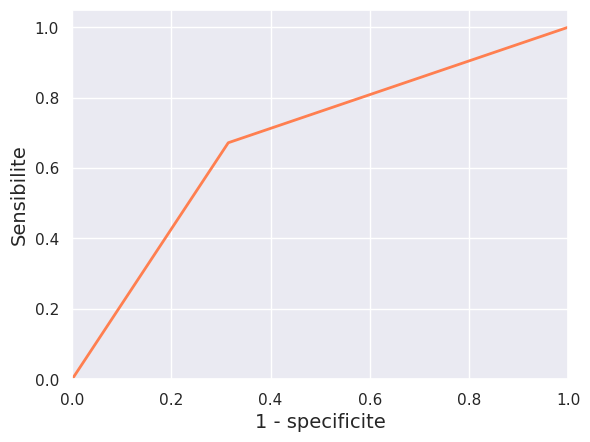

In [21]:
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95))

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1 - fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

# Profits and Loss function

In [22]:
def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [23]:
# compute mean ratio of value of goods, and amount loaned for buying this goods
GOODS_CREDIT_RATIO = (
    app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_GOODS_PRICE
    / app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_CREDIT
).mean()


def pnl(y_pred, y_true, interest=0.04, goods_recover_rate=0.60):
    # ajouter type casting
    # todo X en param
    # df.apply(pnl)
    # y_proba
    # interest  et GOODS_P en param
    # interest = 0.04
    # goods_recover_rate = 0.60
    credit = app_train.loc[X_test.index, "AMT_CREDIT"]
    # when goods value is missing, use 90% of credit amount
    seized_goods = (
        np.where(
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"].notna(),
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"],
            app_train.loc[X_test.index, "AMT_CREDIT"] * GOODS_CREDIT_RATIO,
        )
        * goods_recover_rate
    )
    pnl = pd.Series(np.nan)
    # TP : pret refusé correctement = pas de perte
    pnl = np.where((y_pred == 1) & (y_true == 1), 0, pnl)
    # FP : pret refusé par erreur : perte des interets
    pnl = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * interest,
        pnl,
    )
    # TN : pret accordé correctement : gain des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * interest,
        pnl,
    )
    # FN : pret accordé par erreur : perte du montant du pret et des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit * (1 + interest) + seized_goods,
        pnl,
    )
    return pnl.sum()

In [24]:
print("P&L avec prédictions modèle : $", human_format(pnl(y_pred, y_test)))
print("P&L avec prédictions parfaites : $", human_format(pnl(y_test, y_test)))

P&L avec prédictions modèle : $ 63.2M
P&L avec prédictions parfaites : $ 1.03B


In [25]:
y_pred.mean()

0.34344310273809264

In [26]:
y_test.mean()

0.08021332408350858

## Essai non concluant : calculer intérêts et durée du prêt en fonction du montant total et de l'annuity

In [27]:
app_train[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]].sample(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,,,
322577,948582.0,33736.5,679500.0
213522,894906.0,26293.5,747000.0
245053,776254.5,23665.5,589500.0
365017,180000.0,9000.0,180000.0
139987,436360.5,35113.5,373500.0
161006,1256400.0,36864.0,900000.0
305904,755190.0,33264.0,675000.0
167287,808650.0,26086.5,675000.0
369714,254700.0,16276.5,225000.0


In [28]:
(app_train.AMT_ANNUITY / app_train.AMT_CREDIT).describe()

# app_train.AMT_CREDIT * 1.0665 / app_train.AMT_ANNUITY

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
dtype: float64

# Shap values

In [29]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

array([[0.005732502738214933, -0.11949141341576791,
        -0.026615856350538907, ..., -26219.374923096744,
        -0.07978795758182905, 0.019009465769855113],
       [0.005732502738214933, 0.0865282648872802, -0.026615856350538907,
        ..., -15386.061316437566, 0.15164159928418763,
        0.017150134832964275],
       [0.005732502738214933, 0.0865282648872802, 0.009844220841980144,
        ..., 6280.565896880789, 0.09437019165156936,
        0.014891606524861751],
       ...,
       [0.005732502738214933, 0.0865282648872802, -0.026615856350538907,
        ..., -16830.50313065879, -0.12202285664681012,
        -0.018426510117922523],
       [-0.04203835341357618, 0.0865282648872802, 0.009844220841980144,
        ..., -28386.03764442858, -0.06195053075159271,
        0.002306261250482104],
       [0.005732502738214933, 0.0865282648872802, 0.009844220841980144,
        ..., -11052.735873773896, -0.05288440058581142,
        0.007997332667415296]], dtype=object)

In [45]:
X_train.sample()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,FE_DAYS_EMPLOYED_PERC,FE_INCOME_CREDIT_PERC,FE_INCOME_PER_PERSON,FE_ANNUITY_INCOME_PERC,FE_PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
128656,0,0,0,1,225000.0,1096020.0,56092.5,900000.0,0.020713,-11100,...,True,False,False,True,False,0.280901,0.205288,75000.0,0.2493,0.051178


In [ ]:
explainer

In [42]:
len(shap_values)

46127

In [43]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [30]:
X_test.shape

(46127, 242)

In [31]:
X_test.shape

(46127, 242)

In [151]:
def shap_for_one(df, idx):
    """
    Return 20
    TODO
    """
    shap_for_sample = pd.DataFrame(explainer.shap_values(df.loc[idx, :])).fillna(0)
    shap_OK = StandardScaler().fit_transform(shap_for_sample)
    shap_OK = pd.DataFrame(shap_OK, index=df.columns)
    shap_OK = pd.Series(shap_OK.iloc[:, 0])
    top_shap = shap_OK.sort_values(ascending=False).head(10)
    bottom_shap = shap_OK.sort_values(ascending=True).head(10)
    return {"top": top_shap.to_dict(), "bottom": bottom_shap.to_dict()}

shap_for_one(X_test, X_test.sample().index[0])

{'top': {'AMT_CREDIT': 4.129715433620307,
  'AMT_INCOME_TOTAL': 0.8232857461793862,
  'FE_INCOME_PER_PERSON': 0.5389226274328889,
  'AMT_ANNUITY': 0.34961838684147095,
  'DAYS_LAST_PHONE_CHANGE': 0.0428491743859195,
  'NAME_EDUCATION_TYPE_Incomplete higher': 0.03877050139967813,
  'FLAG_EMP_PHONE': 0.038769172597491665,
  'FLAG_DOCUMENT_3': 0.03876709225115629,
  'ORGANIZATION_TYPE_XNA': 0.03876637749776808,
  'FLAG_ANOMALY_DAYS_EMPLOYED': 0.03876637749776808},
 'bottom': {'AMT_GOODS_PRICE': -14.949964954460894,
  'DAYS_REGISTRATION': -0.016024734012685768,
  'DAYS_BIRTH': 0.01792093755671402,
  'DAYS_ID_PUBLISH': 0.03205292842258939,
  'NAME_INCOME_TYPE_Pensioner': 0.038743304504785,
  'HOUR_APPR_PROCESS_START': 0.038751962002762264,
  'NAME_EDUCATION_TYPE_Secondary / secondary special': 0.03875349127405482,
  'OBS_30_CNT_SOCIAL_CIRCLE': 0.038754755011199855,
  'EXT_SOURCE_2': 0.03875713762680495,
  'OBS_60_CNT_SOCIAL_CIRCLE': 0.03875935744377403}}

In [138]:
idx = X_test.sample().index[0]

In [133]:
X_test.loc[X_test.sample().index[0], :]

NAME_CONTRACT_TYPE               0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  1
CNT_CHILDREN                     0
AMT_INCOME_TOTAL          157500.0
                            ...   
FE_DAYS_EMPLOYED_PERC     0.090781
FE_INCOME_CREDIT_PERC     0.150553
FE_INCOME_PER_PERSON       78750.0
FE_ANNUITY_INCOME_PERC    0.195029
FE_PAYMENT_RATE           0.029362
Name: 287978, Length: 242, dtype: object

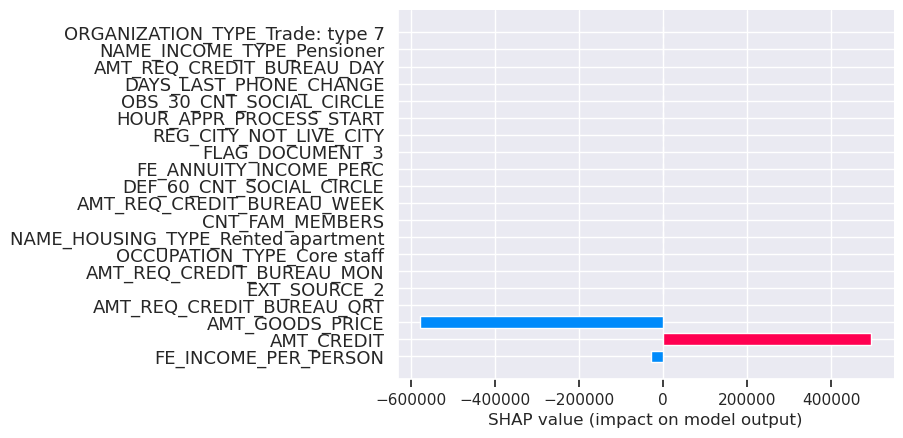

In [44]:
# explainer for only 1 sample row
# TODO prendre que les tops
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [34]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

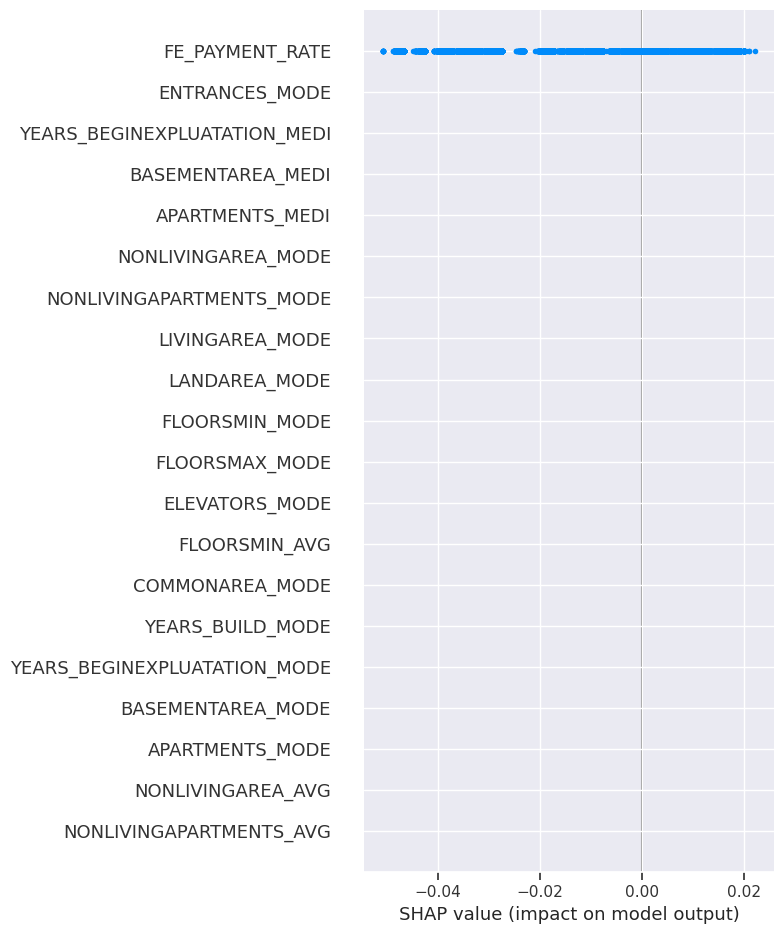

In [35]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    # use_log_scale=True,
)

# Data Drift
Pour simuler évolution des commportements utilisateurs dans le temps, on fait l'hypothèse que `app_train` représente les données d'entrainement et `app_test` les données de test.  
On applique le même nettoyage à train et test

In [36]:
# Third party
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report

# data_drift_report = Report(
#     metrics=[
#         DataDriftPreset(),
#     ]
# )

# data_drift_report.run(
#     reference_data=app_train.sample(frac=0.05).drop("TARGET", axis=1),
#     current_data=app_test.sample(frac=0.05),
#     # column_mapping=None,
# )

# data_drift_report.save_html("../reports/data_drift_report.html")

In [37]:
# ! firefox ../reports/data_drift_report.html

# Save trained model

In [38]:
# Standard
import pickle

with open("../models/model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)
with open("../models/shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

f.close()

In [39]:
grid.best_estimator_.predict_proba(pd.DataFrame(X_test.iloc[0, :]).T)

array([[0.59076465, 0.40923535]])